# scRNA-Seq analysis to trace macrophage fate

## Import and settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pyranges as pr

In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

/Users/feifei/miniconda3/envs/scrna-macro/bin/python
3.6.12 | packaged by conda-forge | (default, Dec  9 2020, 00:24:39) 
[GCC Clang 11.0.0]
sys.version_info(major=3, minor=6, micro=12, releaselevel='final', serial=0)
scanpy==1.7.1 anndata==0.7.5 umap==0.4.6 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sc.settings.set_figure_params(dpi=80)

In [4]:
data_dir = '../data/'
work_dir = '../results/'
h5ad_dir = work_dir + 'h5ad/'

In [5]:
%load_ext rpy2.ipython

## Introduction

There are in total 4 plates of 384 well, two from 2019 and two from 2020. Well P23 and P24 were recommendated to be negative control for the sample plates. So there are in total 1528 single cells sequenced.

The sequencing center originally mapped the reads to their reference and provided counts and rpkm values, but apparently the reference genome do not contain mitochondrial sequence, and mapping rate to MT is apparently one quality control in scRNA-Seq analysis to determine if the cell is dying. (High content of MT RNA may indicated apoptosis)

## Sample info

D21 - means 21 days after ischemia
GFP_plus - high pdgfrb expression
tdtomato_plus - permenant, lineage tracing marker. Indicate macrophage, Cx3cr1 expression, but there were some cells in D21 seem to have lost Cx3cr1 expression.
tdtomato_minus - pericytes. But there are 30% macrophages that don't express tdtomato, so there is still possibility that it could be a macrophage.

cell_identity | explanation 
------------- | -----------
D21_tdtomato_minus_GFP_plus | Pericytes, but with possibility of being macrophages
D21_tdtomato_plus_GFP_plus | Macrophages, that have both tdtomato red and Pdgfrb GFP expression. There were some indication that having both might downregulate Cx3cr1 expression
D21_tdtomato_plus_GFP_plusminus | Macrophages, tdtomato red but difficult to say if it has also Pdgfrb expression due to weak expression
Healthy_tdtomato_minus_GFP_plus | Pericytes
Healthy_tdtomato_plus_GFP_plusminus | Macrophages

One thinking is to only look at tdtomato_plus to see if it gives better clustering

In [6]:
sample_info_file = data_dir + 'sampleinfo.csv'
sample_info = pd.read_csv(sample_info_file, sep=',', header=0, index_col=False)
sample_info.head()

,rownames,sortdate,cell_identity,ischemia,marker,sex,sorting_batch,plate_id,PDGFRB_MFI
0,A1,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,276,1375.668366
1,A2,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,276,1653.849069
2,A3,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,276,924.568909
3,A4,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,276,443.811235
4,A5,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,276,445.761094


In [7]:
sample_info[['sortdate', 'cell_identity']].apply(pd.value_counts)

,sortdate,cell_identity
2019_09_18,768.0,NaN
2020_06_24,768.0,NaN
D21_tdtomato_minus_GFP_plus,NaN,372.0
D21_tdtomato_plus_GFP_plus,NaN,359.0
D21_tdtomato_plus_GFP_plusminus,NaN,396.0
Healthy_tdtomato_minus_GFP_plus,NaN,192.0
Healthy_tdtomato_plus_GFP_plusminus,NaN,190.0
blank,NaN,27.0


In [8]:
sample_info.shape

(1536, 9)

### Add GFP and tdtomato

In [9]:
sample_info['GFP'] = [x.split('_')[-1] for x in sample_info['cell_identity']]
tdtomato = []
for x in sample_info['cell_identity']:
    arr = x.split('_')
    if len(arr) >1:
        tdtomato.append(arr[2])
    else:
        tdtomato.append('blank')

sample_info['tdtomato'] = tdtomato

In [10]:
sample_info.tail()

,rownames,sortdate,cell_identity,ischemia,marker,sex,sorting_batch,plate_id,PDGFRB_MFI,GFP,tdtomato
1531,P20,2020_06_24,Healthy_tdtomato_plus_GFP_plusminus,healthy,tdtomato_plus_GFP_plusminus,female,2,31,120.879804,plusminus,plus
1532,P21,2020_06_24,Healthy_tdtomato_plus_GFP_plusminus,healthy,tdtomato_plus_GFP_plusminus,female,2,31,348.825375,plusminus,plus
1533,P22,2020_06_24,Healthy_tdtomato_plus_GFP_plusminus,healthy,tdtomato_plus_GFP_plusminus,female,2,31,-850.127300,plusminus,plus
1534,P23,2020_06_24,blank,blank,blank,blank,2,31,NaN,blank,blank
1535,P24,2020_06_24,blank,blank,blank,blank,2,31,NaN,blank,blank


## Mapping stats - STAR

`count_table.sh` was used to parse `*_Log.final.out` and `*_ReadsPerGene.out.tab` to get `year, plate, well, n_reads, n_mapped_reads, p_mapped_reads, n_reads_in_features, p_reads_in_features, n_multi_mapped_reads, p_multi_mapped_reads, n_short_unmapped_reads, p_short_unmapped_reads, p_other`. Combined with `2019_2020_sampleinfo_276\ and\ 278_31\ and\ 33.csv` provided by Kristel. We have a complete table about the information of each cell, and its mapping info

### `fastqc` to check read quality

`fastqc` reveals that the reads are of good per base quality. Most of them have around 20% duplicated reads, and there is some overrepresented sequences. And there is no sign of adapter sequence.
Since I don't find any recommendation in trimming the reads before mapping rna-seq reads, I'll go ahead map the reads to mouse genome without trimming

### Re-mapping with `STAR`

`STAR` v2.7.7a is used for remapping. 

Reference genome and annotation were downloaded from https://www.gencodegenes.org/mouse/release_M25.html

Nucleotide sequence of the GRCm38 primary genome assembly (chromosomes and scaffolds) `GRCm38.primary_assembly.genome.fa`
Comprehensive gene annotation on the primary assembly (chromosomes and scaffolds) sequence regions `gencode.vM25.primary_assembly.annotation.gtf`

### Read in mapping stats - STAR

In [11]:
mapping_stats_file = data_dir + 'mapping_stats.txt'
mapping_stats = pd.read_csv(mapping_stats_file, sep='\t', header=0, index_col=False)
mapping_stats.head()

,prefix,year,plate,well,n_reads,n_mapped_reads,p_mapped_reads,n_reads_in_features,p_reads_in_features,n_multi_mapped_reads,p_multi_mapped_reads,n_short_unmapped_reads,p_short_unmapped_reads,p_other
0,SS2_19_276_A10,19,276,A10,739368,532454,72.01%,340945,46.11%,73528,9.94%,118826,16.07%,1.96%
1,SS2_19_276_A11,19,276,A11,687286,498373,72.51%,292310,42.53%,79454,11.56%,93006,13.53%,2.39%
2,SS2_19_276_A12,19,276,A12,724271,507722,70.10%,296117,40.88%,101910,14.07%,90630,12.51%,3.31%
3,SS2_19_276_A13,19,276,A13,589790,325583,55.20%,171705,29.11%,74209,12.58%,175538,29.76%,2.45%
4,SS2_19_276_A14,19,276,A14,719070,541450,75.29%,324420,45.11%,69945,9.72%,91083,12.66%,2.30%


In [12]:
stats = pd.merge(mapping_stats, sample_info, how='left', left_on=['plate', 'well'], right_on=['plate_id', 'rownames'])
cell_stats = stats.drop(['plate_id', 'rownames'], axis=1)
cell_stats = cell_stats.set_index('prefix')
cell_stats.head()

,year,plate,well,n_reads,n_mapped_reads,p_mapped_reads,n_reads_in_features,p_reads_in_features,n_multi_mapped_reads,p_multi_mapped_reads,n_short_unmapped_reads,p_short_unmapped_reads,p_other,sortdate,cell_identity,ischemia,marker,sex,sorting_batch,PDGFRB_MFI,GFP,tdtomato
prefix,,,,,,,,,,,,,,,,,,,,,,
SS2_19_276_A10,19,276,A10,739368,532454,72.01%,340945,46.11%,73528,9.94%,118826,16.07%,1.96%,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,583.878153,plusminus,plus
SS2_19_276_A11,19,276,A11,687286,498373,72.51%,292310,42.53%,79454,11.56%,93006,13.53%,2.39%,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,515.783788,plusminus,plus
SS2_19_276_A12,19,276,A12,724271,507722,70.10%,296117,40.88%,101910,14.07%,90630,12.51%,3.31%,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,828.602381,plusminus,plus
SS2_19_276_A13,19,276,A13,589790,325583,55.20%,171705,29.11%,74209,12.58%,175538,29.76%,2.45%,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,103.359977,plusminus,plus
SS2_19_276_A14,19,276,A14,719070,541450,75.29%,324420,45.11%,69945,9.72%,91083,12.66%,2.30%,2019_09_18,D21_tdtomato_plus_GFP_plusminus,D21,tdtomato_plus_GFP_plusminus,male,1,768.046816,plusminus,plus


### mapping distribution
Plot total number of reads mapped from each cell, separated as uniquely mapped, multi-mapped and unmapped. There are some with very low mappings, are those negative controls?

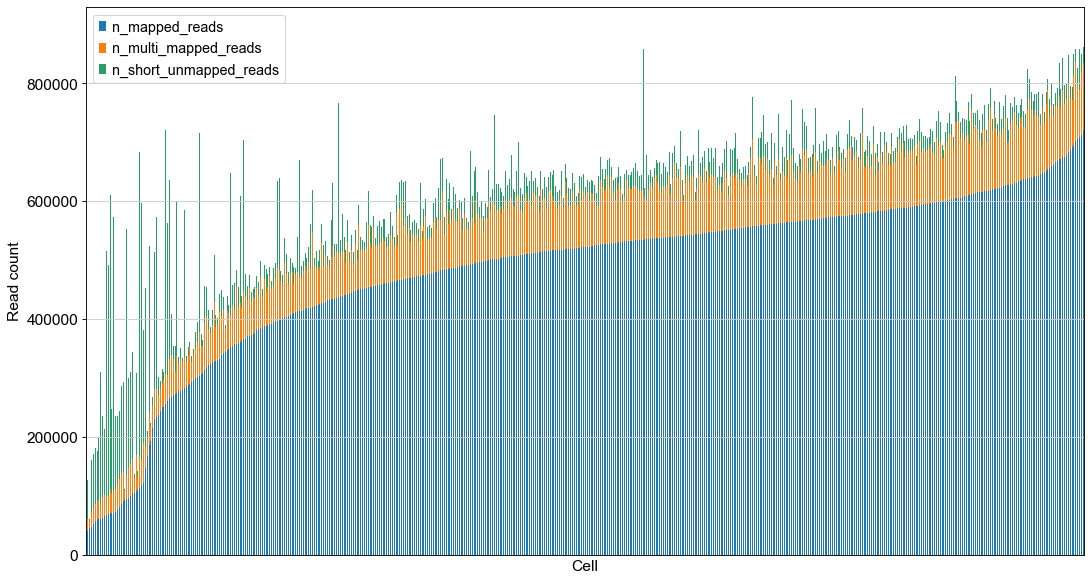

In [13]:
plt.rcParams["figure.figsize"] = [16,9]
sorted_cells = cell_stats[['n_mapped_reads', 'n_multi_mapped_reads', 'n_short_unmapped_reads']].\
               sort_values(by='n_mapped_reads', ascending=True).reset_index(drop=True)
sorted_cells.plot(kind='bar', stacked=True)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticks([])
frame1.axes.xaxis.set_ticklabels([])
plt.xlabel('Cell')
plt.ylabel('Read count')
plt.show()

### Handle negative controls 

In [14]:
cell_stats.loc[cell_stats['marker'] == 'blank'][['cell_identity', 'ischemia', 'marker', 'sex']]

,cell_identity,ischemia,marker,sex
prefix,,,,
SS2_19_276_P23,blank,D21,blank,male
SS2_19_276_P24,blank,D21,blank,male
SS2_19_278_P23,blank,blank,blank,blank
SS2_19_278_P24,blank,blank,blank,blank
SS2_20_031_P23,blank,blank,blank,blank
SS2_20_031_P24,blank,blank,blank,blank
SS2_20_033_P10,blank,blank,blank,blank
SS2_20_033_P11,blank,blank,blank,blank
SS2_20_033_P12,blank,blank,blank,blank


In [15]:
# Correct ischemia and sex for SS2_19_276_P23 and SS2_19_276_P24
cell_stats.loc[cell_stats.index.isin(['SS2_19_276_P23', 'SS2_19_276_P24']), ['ischemia', 'sex']] = 'blank'

In [16]:
cell_stats.loc[cell_stats['marker'] == 'blank'][['cell_identity', 'ischemia', 'marker', 'sex']].head()

,cell_identity,ischemia,marker,sex
prefix,,,,
SS2_19_276_P23,blank,blank,blank,blank
SS2_19_276_P24,blank,blank,blank,blank
SS2_19_278_P23,blank,blank,blank,blank
SS2_19_278_P24,blank,blank,blank,blank
SS2_20_031_P23,blank,blank,blank,blank


## Build adata

Create an anndata.AnnData object, which stores the count matrix in `X`, gene information in `var` and cell information in `obs`. 

### X matrix from counts

Counts were generated with `featureCounts`

In [17]:
counts_file = data_dir + 'counts.txt'

In [18]:
adata = sc.read_csv(counts_file, delimiter=None, first_column_names=True)
adata = adata.transpose()
adata

AnnData object with n_obs × n_vars = 1536 × 55487

### Build var table

var is a data frame that stores gene level information. Often indexed with gene_name

gtf file has 55487 gene

In [19]:
gtf_file = data_dir + 'gencode.vM25.primary_assembly.annotation.gtf'
genes = pr.read_gtf(gtf_file, as_df = True)
#genes = genes.df
genes.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,gene_name,level,mgi_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,protein_id,ccdsid,ont
0,chr1,HAVANA,gene,3073252,3074322,.,+,.,ENSMUSG00000102693.1,TEC,4933401J01Rik,2,MGI:1918292,OTTMUSG00000049935.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,3073252,3074322,.,+,.,ENSMUSG00000102693.1,TEC,4933401J01Rik,2,MGI:1918292,OTTMUSG00000049935.1,ENSMUST00000193812.1,TEC,4933401J01Rik-201,NA,basic,OTTMUST00000127109.1,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,3073252,3074322,.,+,.,ENSMUSG00000102693.1,TEC,4933401J01Rik,2,MGI:1918292,OTTMUSG00000049935.1,ENSMUST00000193812.1,TEC,4933401J01Rik-201,NA,basic,OTTMUST00000127109.1,1,ENSMUSE00001343744.1,NaN,NaN,NaN
3,chr1,ENSEMBL,gene,3102015,3102125,.,+,.,ENSMUSG00000064842.1,snRNA,Gm26206,3,MGI:5455983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,ENSEMBL,transcript,3102015,3102125,.,+,.,ENSMUSG00000064842.1,snRNA,Gm26206,3,MGI:5455983,NaN,ENSMUST00000082908.1,snRNA,Gm26206-201,NA,basic,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
genes = genes[genes['Feature'] == 'gene']

In [21]:
genes.columns

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id',
       'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name',
       'transcript_support_level', 'tag', 'havana_transcript', 'exon_number',
       'exon_id', 'protein_id', 'ccdsid', 'ont'],
      dtype='object')

In [22]:
genes = genes[['Chromosome', 'Source', 'gene_id', 'gene_name']].set_index('gene_name')

In [23]:
adata.var = genes

In [24]:
adata.var_names_make_unique()

In [25]:
adata

AnnData object with n_obs × n_vars = 1536 × 55487
    var: 'Chromosome', 'Source', 'gene_id'

normalizing counts per cell
    finished (0:00:00)


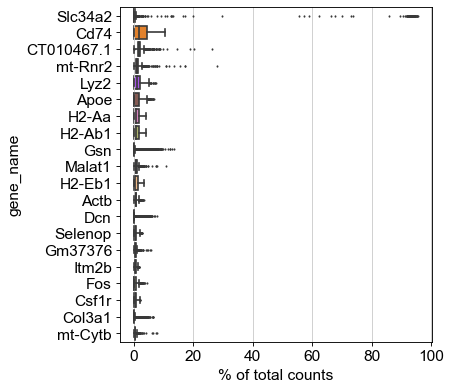

In [26]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Obs table 

obs is a data frame stores cells meta data.

In [27]:
adata.obs = cell_stats

In [28]:
adata.obs.columns

Index(['year', 'plate', 'well', 'n_reads', 'n_mapped_reads', 'p_mapped_reads',
       'n_reads_in_features', 'p_reads_in_features', 'n_multi_mapped_reads',
       'p_multi_mapped_reads', 'n_short_unmapped_reads',
       'p_short_unmapped_reads', 'p_other', 'sortdate', 'cell_identity',
       'ischemia', 'marker', 'sex', 'sorting_batch', 'PDGFRB_MFI', 'GFP',
       'tdtomato'],
      dtype='object')

In [29]:
adata.obs['cell_identity'].value_counts()

D21_tdtomato_plus_GFP_plusminus        396
D21_tdtomato_minus_GFP_plus            372
D21_tdtomato_plus_GFP_plus             359
Healthy_tdtomato_minus_GFP_plus        192
Healthy_tdtomato_plus_GFP_plusminus    190
blank                                   27
Name: cell_identity, dtype: int64

## QC

Quality metrics including the percentage of mitocondrial and ribosomal genes per cell. High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.


### Calculate QC metrics

In [30]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('mt-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('Mrps','Mrpl'))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.startswith(("Hba"))

adata.var

,Chromosome,Source,gene_id,mt,ribo,hb
gene_name,,,,,,
4933401J01Rik,chr1,HAVANA,ENSMUSG00000102693.1,False,False,False
Gm26206,chr1,ENSEMBL,ENSMUSG00000064842.1,False,False,False
Xkr4,chr1,HAVANA,ENSMUSG00000051951.5,False,False,False
Gm18956,chr1,HAVANA,ENSMUSG00000102851.1,False,False,False
Gm37180,chr1,HAVANA,ENSMUSG00000103377.1,False,False,False
...,...,...,...,...,...,...
AC124606.1,JH584299.1,ENSEMBL,ENSMUSG00000095523.1,False,False,False
AC133095.2,JH584299.1,ENSEMBL,ENSMUSG00000095475.1,False,False,False
AC133095.1,JH584299.1,ENSEMBL,ENSMUSG00000094855.1,False,False,False


In [31]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [32]:
adata

AnnData object with n_obs × n_vars = 1536 × 55487
    obs: 'year', 'plate', 'well', 'n_reads', 'n_mapped_reads', 'p_mapped_reads', 'n_reads_in_features', 'p_reads_in_features', 'n_multi_mapped_reads', 'p_multi_mapped_reads', 'n_short_unmapped_reads', 'p_short_unmapped_reads', 'p_other', 'sortdate', 'cell_identity', 'ischemia', 'marker', 'sex', 'sorting_batch', 'PDGFRB_MFI', 'GFP', 'tdtomato', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'Chromosome', 'Source', 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [33]:
adata.var.head()

,Chromosome,Source,gene_id,mt,ribo,hb,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
gene_name,,,,,,,,,,
4933401J01Rik,chr1,HAVANA,ENSMUSG00000102693.1,False,False,False,2,0.022786,99.869792,35.0
Gm26206,chr1,ENSEMBL,ENSMUSG00000064842.1,False,False,False,3,0.002604,99.804688,4.0
Xkr4,chr1,HAVANA,ENSMUSG00000051951.5,False,False,False,15,0.173177,99.023438,266.0
Gm18956,chr1,HAVANA,ENSMUSG00000102851.1,False,False,False,3,0.024089,99.804688,37.0
Gm37180,chr1,HAVANA,ENSMUSG00000103377.1,False,False,False,14,0.112630,99.088542,173.0


### Save & read data 

In [34]:
adata.layers['raw'] = adata.X
adata.obsm['raw'] = adata.X

In [35]:
adata.write_h5ad(h5ad_dir + 'adata.raw.h5ad')

... storing 'well' as categorical
... storing 'p_mapped_reads' as categorical
... storing 'p_reads_in_features' as categorical
... storing 'p_multi_mapped_reads' as categorical
... storing 'p_short_unmapped_reads' as categorical
... storing 'p_other' as categorical
... storing 'sortdate' as categorical
... storing 'cell_identity' as categorical
... storing 'ischemia' as categorical
... storing 'marker' as categorical
... storing 'sex' as categorical
... storing 'GFP' as categorical
... storing 'tdtomato' as categorical
... storing 'Chromosome' as categorical
... storing 'Source' as categorical


In [36]:
adata = sc.read_h5ad(h5ad_dir + 'adata.raw.h5ad')

### Plot QC

Look at gene counts, total counts, MT percentage, ribosomal protein percentage and hemoglobin percentage, grouped by cell identity, batch, sex. 
Besides the empty well (negative controls), there are a few other cells that are sequenced at low coverage, might also be empty. Those should be filtered. High MT is only present at a few cells, while majority of them have MT percent belo 10%, and that would also be one of the cutoff.
The batch sequenced in 2020 seems to have slightly higher depth, and slightly higher MT percent, indicating batch effect, would try integration to remove batch effort later.

Percent ribosomal protein is very low. Normally it's one of the mostly expressed genes, so is it a smartseq2 feature or is it an indication of low cell quality? 

In [37]:
sc.settings.set_figure_params(dpi=80)

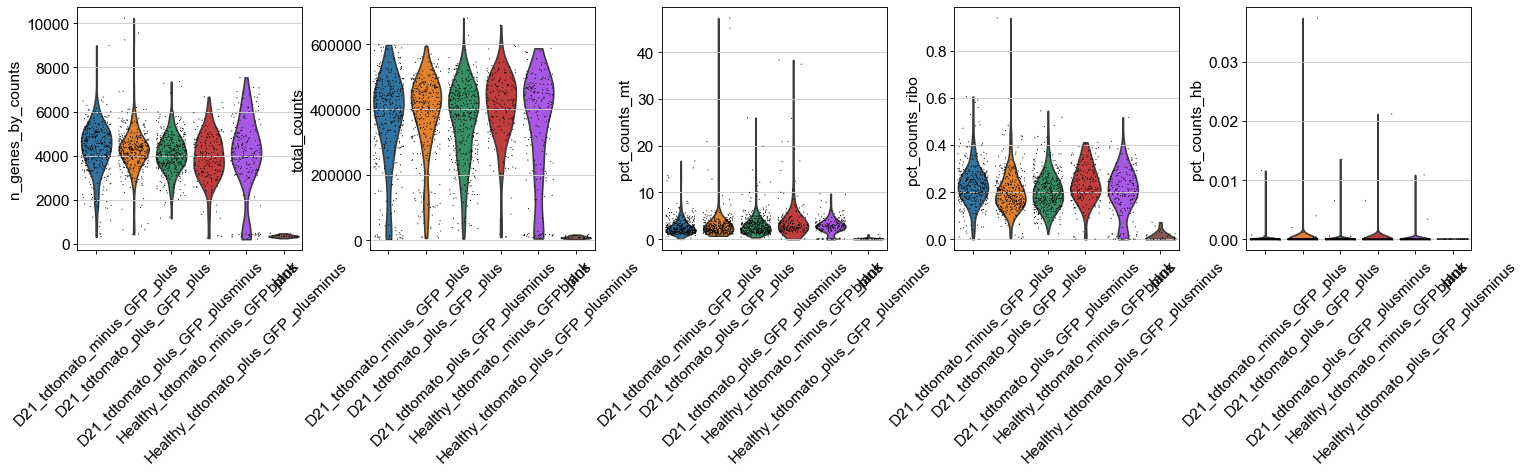

In [38]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'cell_identity', rotation= 45)

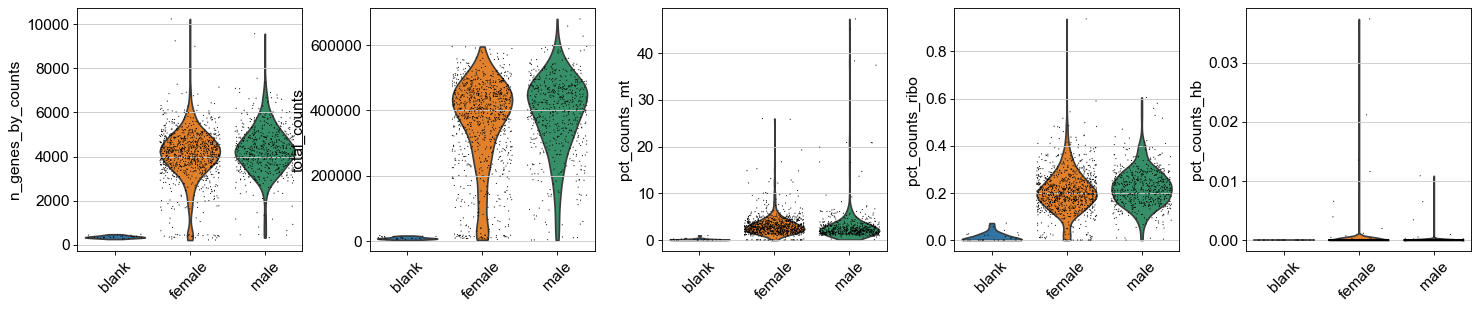

In [39]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sex', rotation= 45)

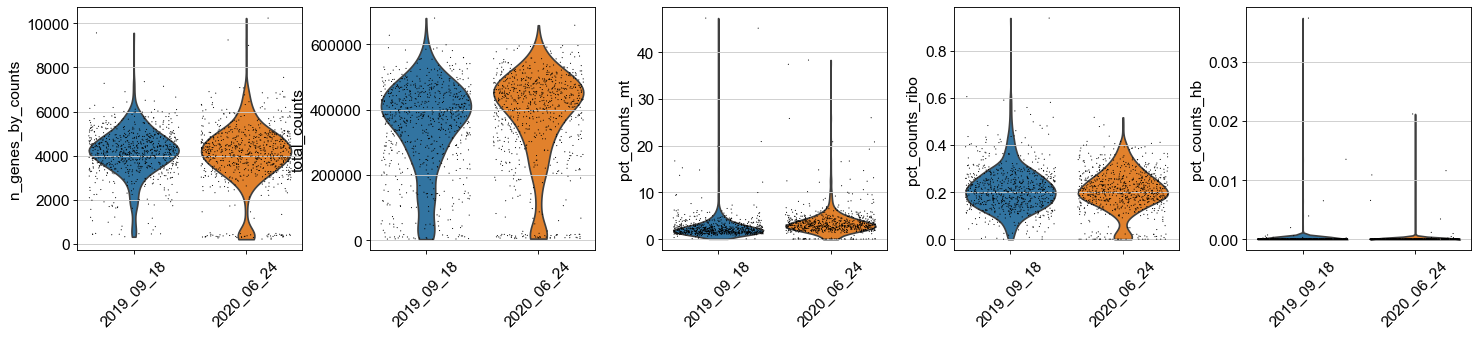

In [40]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sortdate', rotation= 45)

Empty cells clustered at the low left corner, and the cells close to them should also be filtered

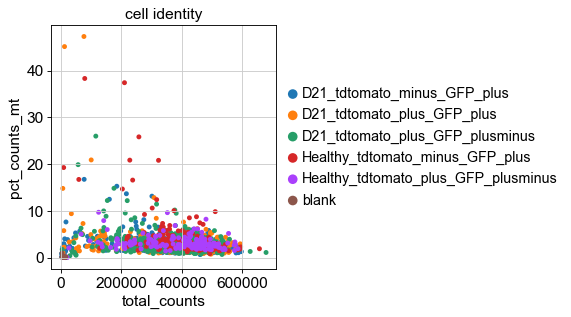

In [41]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="cell_identity")

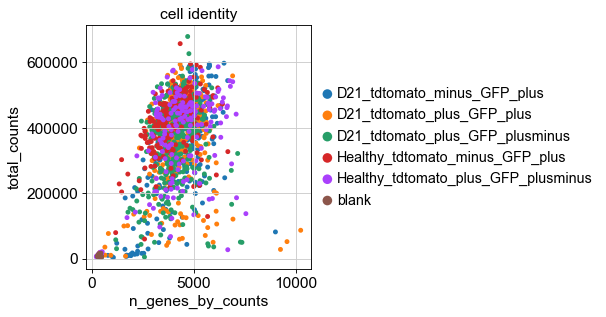

In [42]:
sc.pl.scatter(adata, x='n_genes_by_counts', y='total_counts', color="cell_identity")

### Filtering

A standard approach is to filter cells with low amount of reads as well as genes that are present in at least a certain amount of cells. This will also filter those empty wells. Here we will only consider cells with at least 500 detected genes and genes need to be expressed in at least 3 cells. Please note that those values are highly dependent on the library preparation method used.

In [43]:
adata.obs[adata.obs.sex == 'blank']

,year,plate,well,n_reads,n_mapped_reads,p_mapped_reads,n_reads_in_features,p_reads_in_features,n_multi_mapped_reads,p_multi_mapped_reads,n_short_unmapped_reads,p_short_unmapped_reads,p_other,sortdate,cell_identity,ischemia,marker,sex,sorting_batch,PDGFRB_MFI,GFP,tdtomato,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb
prefix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SS2_19_276_P23,19,276,P23,396958,43143,10.86%,4621,1.16%,22531,5.67%,326740,82.31%,1.14%,2019_09_18,blank,blank,blank,blank,1,NaN,blank,blank,438,4728.0,47.0,0.994078,0.0,0.000000,0.0,0.0
SS2_19_276_P24,19,276,P24,312046,50720,16.25%,5304,1.69%,27820,8.91%,228009,73.06%,1.76%,2019_09_18,blank,blank,blank,blank,1,NaN,blank,blank,458,5391.0,5.0,0.092747,3.0,0.055648,0.0,0.0
SS2_19_278_P23,19,278,P23,228504,51634,22.59%,4046,1.77%,23880,10.45%,148459,64.96%,1.98%,2019_09_18,blank,blank,blank,blank,1,NaN,blank,blank,416,4170.0,5.0,0.119904,3.0,0.071942,0.0,0.0
SS2_19_278_P24,19,278,P24,365252,62888,17.21%,6119,1.67%,31761,8.69%,264666,72.46%,1.62%,2019_09_18,blank,blank,blank,blank,1,NaN,blank,blank,476,6470.0,24.0,0.370943,2.0,0.030912,0.0,0.0
SS2_20_031_P23,20,31,P23,265028,86817,32.75%,14771,5.57%,47077,17.76%,117362,44.28%,5.19%,2020_06_24,blank,blank,blank,blank,2,NaN,blank,blank,333,14799.0,5.0,0.033786,1.0,0.006757,0.0,0.0
SS2_20_031_P24,20,31,P24,210645,66695,31.66%,10572,5.01%,35865,17.02%,97647,46.35%,4.95%,2020_06_24,blank,blank,blank,blank,2,NaN,blank,blank,291,10612.0,4.0,0.037693,0.0,0.000000,0.0,0.0
SS2_20_033_P10,20,33,P10,245546,77579,31.59%,10934,4.45%,41695,16.98%,114449,46.61%,4.81%,2020_06_24,blank,blank,blank,blank,2,NaN,blank,blank,327,11003.0,5.0,0.045442,0.0,0.000000,0.0,0.0
SS2_20_033_P11,20,33,P11,188405,56195,29.82%,7540,4.00%,29714,15.77%,94380,50.09%,4.30%,2020_06_24,blank,blank,blank,blank,2,NaN,blank,blank,318,7603.0,1.0,0.013153,2.0,0.026305,0.0,0.0
SS2_20_033_P12,20,33,P12,179864,55231,30.70%,7307,4.06%,28284,15.72%,88493,49.19%,4.36%,2020_06_24,blank,blank,blank,blank,2,NaN,blank,blank,260,7329.0,2.0,0.027289,3.0,0.040933,0.0,0.0


In [44]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 59 cells that have less than 500 genes expressed
filtered out 17276 genes that are detected in less than 3 cells


1477 38211


normalizing counts per cell
    finished (0:00:00)


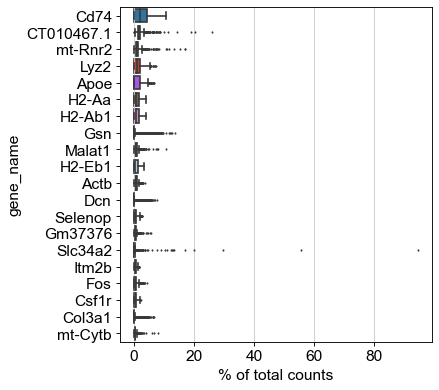

In [45]:
sc.pl.highest_expr_genes(adata, n_top=20)

It's quite normal to see malat1 and mitochondrial genes in the top expressed list.

#### Filter Mito 

Ther is not so much ribosomal proteins or hemoglobins in the data, but there are some cells with high percentage of mitochondrial reads, that could be filtered ou. Since majority of them have mt <10%, will just set the cutoff so.

In [46]:
print("cells %d"%adata.n_obs)
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
print("Remaining cells %d"%adata.n_obs)

cells 1477
Remaining cells 1451


#### Filter malat1 and mt genes

As the level of expression of mitochondrial and MALAT1 genes are judged as mainly technical, it can be wise to remove them from the dataset bofore any further analysis.

In [47]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('malat1')
mito_genes = adata.var_names.str.startswith('mt-')

remove = np.add(mito_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

1451 38211
1451 38178


In [48]:
raw = adata.layers['raw']

### Plot Filtered QC

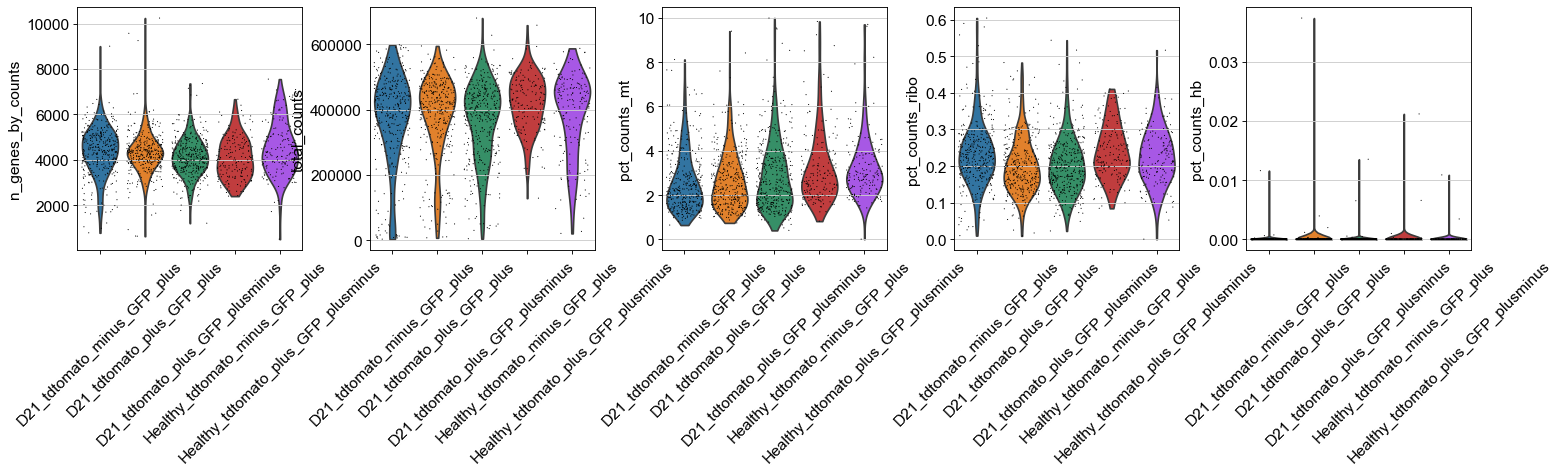

In [49]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'cell_identity', rotation= 45)

### Sample sex

By looking at reads from chromosome Y and XIST (X-inactive specific transcript) expression, it's quite easy to determine per sample which sex it is. It can be a good way to detect id there has been any sample mixup, to see if the sample metadata sex agree with the computational predictions.

It seems that all the ones marked as female are probably female, but not all the ones marked male are real male mice. 

In [50]:
chrY_genes = adata.var_names[adata.var.Chromosome == 'chrY']
chrY_genes

Index(['Rhoay-ps3', 'Kdm5d', 'Eif2s3y', 'Gm29650', 'Uty', 'Ddx3y', 'Gm4017',
       'Usp9y', 'Gm17790', 'Uba1y-ps2', 'Gm18796', 'Gm8498', 'Gm28649',
       'Gm37222', 'Gm29160', 'Gm20775', 'Gapdh-ps15', 'Gm21860', 'Mid1-ps1',
       'Gm47283'],
      dtype='object', name='gene_name')

In [51]:
adata.obs['percent_chrY'] = np.sum(adata[:, chrY_genes].X, axis=1) / np.sum(adata.X, axis=1) * 100

Trying to set attribute `.obs` of view, copying.


In [52]:
adata.obs['XIST-counts'] = adata.X[:, adata.var_names.str.match('Xist')]

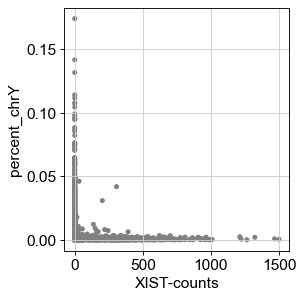

In [53]:
sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY')

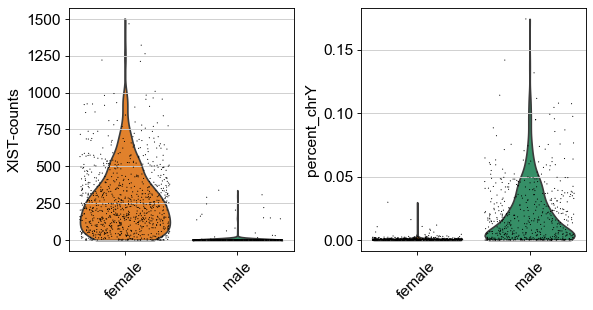

In [54]:
sc.pl.violin(adata, ['XIST-counts', 'percent_chrY'], jitter=0.4, groupby='sex', rotation=45)

#### Makred male, but potentially female

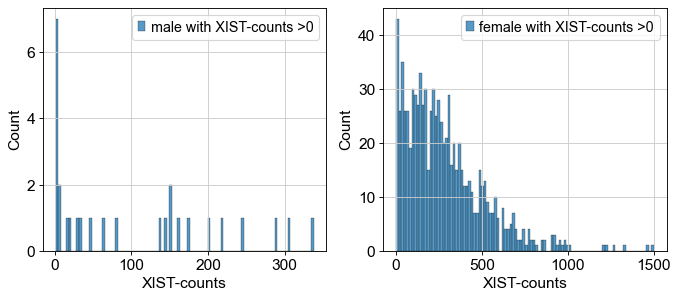

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax = sns.histplot(adata.obs[(adata.obs['XIST-counts'] > 0) & (adata.obs['sex'] == 'male')]['XIST-counts'], 
                  label='male with XIST-counts >0', bins = 100, ax=axes[0])
ax.legend()
ax = sns.histplot(adata.obs[(adata.obs['XIST-counts'] > 0) & (adata.obs['sex'] == 'female')]['XIST-counts'], 
                  label='female with XIST-counts >0', bins = 100, ax=axes[1])
ax.legend()

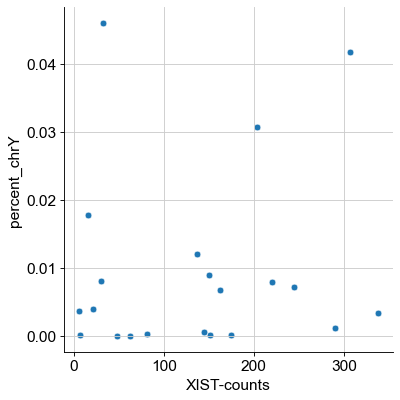

In [56]:
x = adata.obs[(adata.obs['XIST-counts'] > 5) & (adata.obs['sex'] == 'male')]
sns.relplot(x='XIST-counts', y='percent_chrY', data=x);

In [57]:
adata.obs[(adata.obs['XIST-counts'] > 10) & (adata.obs['sex'] == 'male')][['year', 'plate', 'well', 'XIST-counts', 'percent_chrY', 
                                                                           'sex', 'cell_identity', 'PDGFRB_MFI']]

,year,plate,well,XIST-counts,percent_chrY,sex,cell_identity,PDGFRB_MFI
prefix,,,,,,,,
SS2_19_276_L7,19,276,L7,30.0,0.008113,male,D21_tdtomato_plus_GFP_plus,1004.150147
SS2_20_031_A23,20,31,A23,16.0,0.017765,male,Healthy_tdtomato_minus_GFP_plus,5274.526246
SS2_20_031_E10,20,31,E10,62.0,0.000000,male,Healthy_tdtomato_plus_GFP_plusminus,-321.650020
SS2_20_031_H10,20,31,H10,307.0,0.041795,male,Healthy_tdtomato_plus_GFP_plusminus,-141.586271
SS2_20_031_H12,20,31,H12,137.0,0.012103,male,Healthy_tdtomato_plus_GFP_plusminus,296.239909
SS2_20_031_H14,20,31,H14,245.0,0.007218,male,Healthy_tdtomato_plus_GFP_plusminus,349.039724
SS2_20_031_H15,20,31,H15,150.0,0.008957,male,Healthy_tdtomato_plus_GFP_plusminus,581.833398
SS2_20_031_H17,20,31,H17,81.0,0.000248,male,Healthy_tdtomato_plus_GFP_plusminus,-89.832373
SS2_20_031_H18,20,31,H18,151.0,0.000223,male,Healthy_tdtomato_plus_GFP_plusminus,486.215234


In [58]:
adata.obs['contamination'] = 0
adata.obs.loc[(adata.obs['XIST-counts'] > 10) & (adata.obs['sex'] == 'male'), 'contamination'] = 1

In [59]:
# Change sex of plate 278 to female
#adata.obs.loc[adata.obs['plate'] == 278, 'sex'] = 'female'

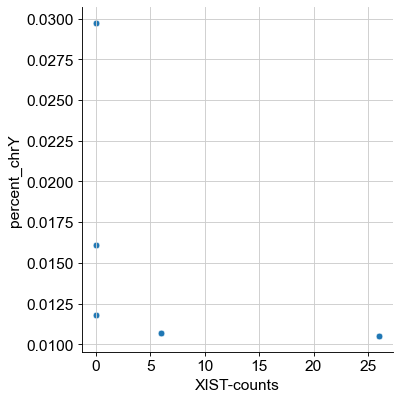

In [60]:
x = adata.obs[(adata.obs['percent_chrY'] > 0.01) & (adata.obs['sex'] == 'female')]
sns.relplot(x='XIST-counts', y='percent_chrY', data=x);

#### Marked female, but potentially male

In [61]:
adata.obs[(adata.obs['percent_chrY'] > 0.01) & (adata.obs['sex'] == 'female')][['year', 'plate', 'well', 'XIST-counts', 'percent_chrY', 
                                                                           'sex', 'cell_identity', 'PDGFRB_MFI']]

,year,plate,well,XIST-counts,percent_chrY,sex,cell_identity,PDGFRB_MFI
prefix,,,,,,,,
SS2_19_278_A14,19,278,A14,0.0,0.016079,female,D21_tdtomato_plus_GFP_plusminus,1005.330655
SS2_19_278_G10,19,278,G10,6.0,0.010692,female,D21_tdtomato_minus_GFP_plus,12354.492130
SS2_19_278_G19,19,278,G19,0.0,0.029744,female,D21_tdtomato_minus_GFP_plus,4929.404087
SS2_19_278_G8,19,278,G8,0.0,0.011763,female,D21_tdtomato_minus_GFP_plus,36323.238740
SS2_19_278_H22,19,278,H22,26.0,0.010496,female,D21_tdtomato_minus_GFP_plus,5591.104271


In [62]:
adata.obs.loc[(adata.obs['percent_chrY'] > 0.01) & (adata.obs['sex'] == 'female') & (adata.obs['XIST-counts'] == 0), 'contamination'] = 1

In [63]:
sum(adata.obs['contamination'])

22

plate 278 is from one mice, and was marked as male, but apparently female according to the data. Fixed in the new meta data

### Calculate cell-cycle scores

The algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycling scoring adds three slots in the data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

In [64]:
cell_cycle_genes_file = data_dir + 'Macosko_cell_cycle_genes.txt'
cell_cycle_genes_df = pd.read_table(cell_cycle_genes_file)
cell_cycle_genes_df

,IG1.S,S,G2.M,M,M.G1,Unnamed: 5
0,ACD,ABCC5,ANLN,AHI1,AGFG1,NaN
1,ACYP1,ABHD10,AP3D1,AKIRIN2,AGPAT3,NaN
2,ADAMTS1,ANKRD18A,ARHGAP19,ANKRD40,AKAP13,NaN
3,ANKRD10,ASF1B,ARL4A,ANLN,AMD1,NaN
4,APEX2,ATAD2,ARMC1,ANP32B,ANP32E,NaN
...,...,...,...,...,...,...
146,NaN,NaN,NaN,YWHAH,NaN,NaN
147,NaN,NaN,NaN,ZC3HC1,NaN,NaN
148,NaN,NaN,NaN,ZFX,NaN,NaN
149,NaN,NaN,NaN,ZMYM1,NaN,NaN


In [65]:
#g1s_genes = cell_cycle_genes_df['IG1.S'].dropna().to_list()
s_genes = [x.lower().capitalize() for x in cell_cycle_genes_df['S'].dropna().to_list()]
g2m_genes = [x.lower().capitalize() for x in cell_cycle_genes_df['G2.M'].dropna().to_list()]
#m_genes = cell_cycle_genes_df['M'].dropna().to_list()
#mg1_genes = cell_cycle_genes_df['M.G1'].dropna().to_list()
#cell_cycle_genes = g1s_genes + s_genes + g2m_genes + m_genes + mg1_genes
cell_cycle_genes = s_genes + g2m_genes
print(len(cell_cycle_genes))
cell_cycle_genes1 = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes1))

246
223


Before running cell cycle we have to normalize the data. In scanpy object, the data slot will be overwriteen with the normalized data. So first, save the raw data into the slot `raw`.

In [66]:
adata.raw = adata

# Normalize to depth 400 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=4e5)
sc.pp.log1p(adata)
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [67]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    1351 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    1453 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


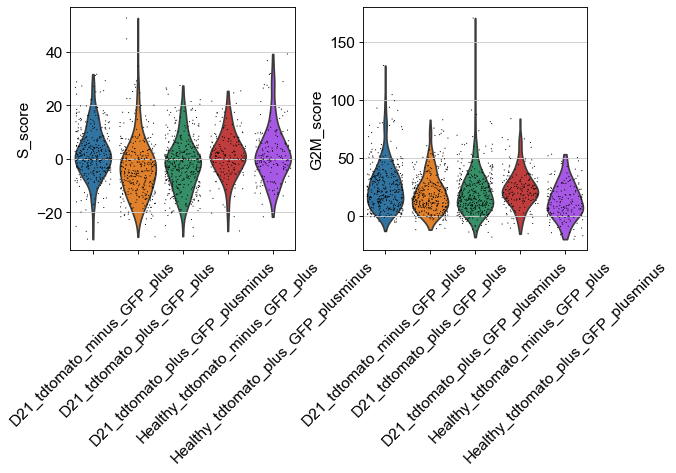

In [68]:
sc.pl.violin(adata, ['S_score', 'G2M_score'], jitter=0.4, groupby='cell_identity', rotation=45)

It looks like majority cells are in G2M phase, with a few in S phase and a few in G1 phase

In [69]:
adata.obs.phase.value_counts()

G2M    1286
S        87
G1       78
Name: phase, dtype: int64

### Predicting doublets

Doublets/Multiple of cells in the same well/droplet is a common issue in scRNAseq protocols. Especially in droplet-based method within overloading of cells.
Since this was flow sorted and seqeunced in smartseq2, we expect low amount of doublets.

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 42.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.2%
Elapsed time: 1.8 seconds


26

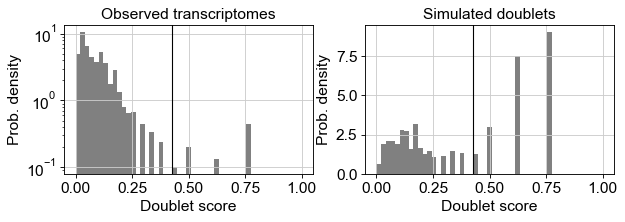

In [70]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])


In [71]:
adata.obs[adata.obs['predicted_doublets'] == True][['year', 'plate', 'well', 'XIST-counts', 'percent_chrY', 
                                                    'sex', 'cell_identity', 'PDGFRB_MFI', 'contamination']]

,year,plate,well,XIST-counts,percent_chrY,sex,cell_identity,PDGFRB_MFI,contamination
prefix,,,,,,,,,
SS2_19_278_B5,19,278,B5,487.0,0.000823,female,D21_tdtomato_plus_GFP_plusminus,579.870965,0
SS2_19_278_L10,19,278,L10,135.0,0.000716,female,D21_tdtomato_plus_GFP_plus,1210.065700,0
SS2_19_278_N21,19,278,N21,185.0,0.000303,female,D21_tdtomato_plus_GFP_plus,1391.709094,0
SS2_19_278_O7,19,278,O7,112.0,0.000000,female,D21_tdtomato_plus_GFP_plus,900.026615,0
SS2_20_031_A18,20,31,A18,1.0,0.060834,male,Healthy_tdtomato_minus_GFP_plus,23461.074810,0
SS2_20_031_E19,20,31,E19,0.0,0.063751,male,Healthy_tdtomato_plus_GFP_plusminus,-755.553366,0
SS2_20_031_H10,20,31,H10,307.0,0.041795,male,Healthy_tdtomato_plus_GFP_plusminus,-141.586271,1
SS2_20_031_H11,20,31,H11,0.0,0.028690,male,Healthy_tdtomato_plus_GFP_plusminus,210.048559,0
SS2_20_031_H12,20,31,H12,137.0,0.012103,male,Healthy_tdtomato_plus_GFP_plusminus,296.239909,1


Many of the predicted doublets were also suspicous contamination based on sex information inconsistency. 

In [72]:
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical
/Users/feifei/miniconda3/envs/scrna-macro/lib/python3.6/site-packages/scanpy/plotting/_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


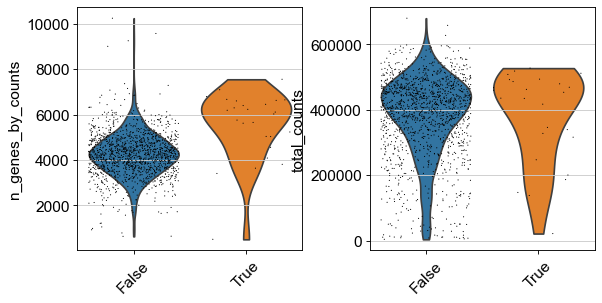

In [73]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'doublet_info', rotation=45)

Now, let's run PCA and UMAP and plot doublet scores onto umap to check the doublet prediction.

In [74]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:07)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


/Users/feifei/miniconda3/envs/scrna-macro/lib/python3.6/site-packages/scanpy/plotting/_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


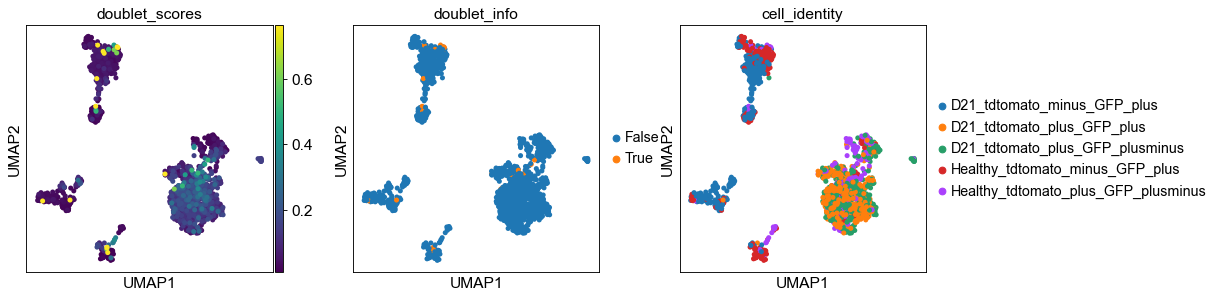

In [75]:
sc.pl.umap(adata, color=['doublet_scores','doublet_info','cell_identity'])

Now, we'll remove all predicted doublets from the data.

In [76]:
# Revert back to the raw counts as the main matrix in the adata
adata = adata.raw.to_adata()
adata.layers['raw'] = raw

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(1425, 38178)


### Save & read data

In [77]:
adata.obsm['raw'] = adata.X

In [78]:
adata.write_h5ad(h5ad_dir + 'adata.filtered.h5ad')

In [79]:
adata = sc.read_h5ad(h5ad_dir + 'adata.filtered.h5ad')

## Normalization & Dimensionality reduction

In [80]:
# Normalize to depth 400 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=4e5)
sc.pp.log1p(adata)

# Store normalized counts in the raw slot.
# We will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata
adata

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 1425 × 38178
    obs: 'year', 'plate', 'well', 'n_reads', 'n_mapped_reads', 'p_mapped_reads', 'n_reads_in_features', 'p_reads_in_features', 'n_multi_mapped_reads', 'p_multi_mapped_reads', 'n_short_unmapped_reads', 'p_short_unmapped_reads', 'p_other', 'sortdate', 'cell_identity', 'ischemia', 'marker', 'sex', 'sorting_batch', 'PDGFRB_MFI', 'GFP', 'tdtomato', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'percent_chrY', 'XIST-counts', 'contamination', 'n_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'Chromosome', 'Source', 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'cell_identity_colors', 'doublet_info_colors', 'hvg', 'neighbors', 'pca', 'sex_colors', 'sortdate_colors', 'umap', 'log1p'
    obsm: 'X_

### Variable genes

We need to define which features/genes are important in our dataset to distinguish cell types. For this, we need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/Users/feifei/miniconda3/envs/scrna-macro/lib/python3.6/site-packages/scanpy/plotting/_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


Highly variable genes: 7421


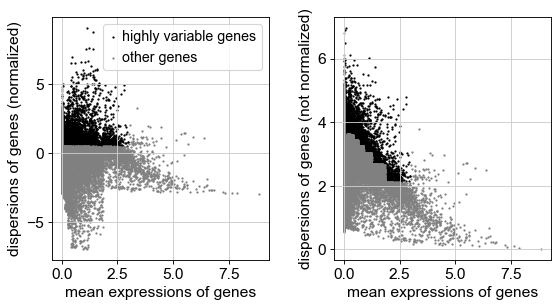

In [81]:
# Compute variable genes
#sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=6, min_disp=0.5)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger')
print('Highly variable genes: %d' %sum(adata.var.highly_variable))

# plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset

In [82]:
adata = adata[:, adata.var['highly_variable']]

### Z-score transformation

Since each gene has a different expression level, it means that genes with higher expression values will naturally have higher variation that will be capured by PCA. This means that we need to somehow give each gene a similar weight when performing PCA. The common practice is to center and scale each gene before performing PCA. This exact scaling is called Z-score normalization. It is very useful for PCA, clustering and plotting heatmaps.

Additionally, we can use regression to remove any unwanted sources of variation from the dataset, such as `cell cycle`, `sequencing depth`, `percent mitochondria`. This is achieved by doing a generalized linear regression using these parameters as covariates in the model. Then the residuals of the model are taken as the 'regressed data'. Although pherphas not in the best way, batch effect regression can also be done here.

In [83]:
# regress out unwanted variables
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:12)


In [84]:
# scale data, clip values exceeding sd 10.
sc.pp.scale(adata, max_value=10)

### PCA

PCA is used to denoise the data

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
/Users/feifei/miniconda3/envs/scrna-macro/lib/python3.6/site-packages/scanpy/plotting/_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


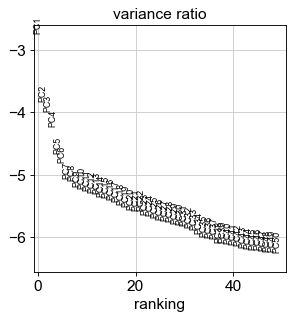

In [85]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

### UMAP

UMAP is the gold standard in dimensionality reduction.
The UMAP implemented in scanpy uses neighborhood graph as the distance matrix, so we need to first calculate the graph

In [86]:
sc.pp.neighbors(adata, n_pcs=40, n_neighbors=20)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


/Users/feifei/miniconda3/envs/scrna-macro/lib/python3.6/site-packages/scanpy/plotting/_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


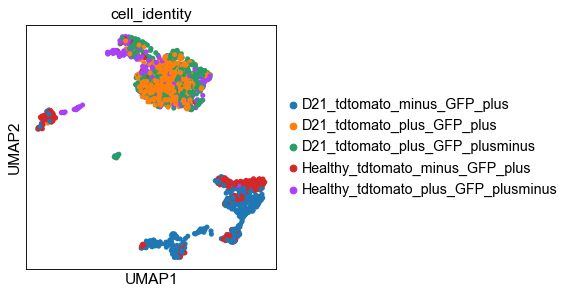

In [87]:
sc.pl.umap(adata, color='cell_identity')

## Integration

### Detect variable genes

Variable genes can be detected across the full dataset, but then we have the risk of having many batch-specific genes that will drive a lot of the variation. Or we can select variable genes from each batch separately to get only celltype variation. In the previous step, we've already selected variable genes, and are stored in 

In [88]:
adata2 = adata.raw.to_adata()

In [89]:
var_genes_all = adata.var.highly_variable
print('Highly variable genes: %d' %sum(var_genes_all))

Highly variable genes: 7421


In [90]:
sc.pp.highly_variable_genes(adata2, flavor='cell_ranger', batch_key='sortdate')
print('Highly variable genes intersection: %d' %sum(adata2.var.highly_variable_intersection))
print('Number of batches where gene is variable:')
print(adata2.var.highly_variable_nbatches.value_counts())

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Highly variable genes intersection: 4431
Number of batches where gene is variable:
0    27364
1     6383
2     4431
Name: highly_variable_nbatches, dtype: int64


In [91]:
var_genes_batch = adata2.var.highly_variable_nbatches >0 

In [92]:
print('Any batch var genes: %d' %sum(var_genes_batch))
print('All data var genes: %d' %sum(var_genes_all))
print('Overlap: %d' %sum(var_genes_batch & var_genes_all))
print('Variable genes in all batches: %d' %sum(adata2.var.highly_variable_nbatches == 2))
print('Overlap batch intersection and all: %d' %sum(var_genes_all & adata2.var.highly_variable_intersection))

Any batch var genes: 10814
All data var genes: 7421
Overlap: 7238
Variable genes in all batches: 4431
Overlap batch intersection and all: 4363


In [93]:
var_select = adata2.var.highly_variable_nbatches >1
var_genes = var_select.index[var_select]
len(var_genes)

4431

In [94]:
batches = adata.obs['sortdate'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['sortdate'] == batch, ]
alldata

{'2019_09_18': View of AnnData object with n_obs × n_vars = 748 × 38178
     obs: 'year', 'plate', 'well', 'n_reads', 'n_mapped_reads', 'p_mapped_reads', 'n_reads_in_features', 'p_reads_in_features', 'n_multi_mapped_reads', 'p_multi_mapped_reads', 'n_short_unmapped_reads', 'p_short_unmapped_reads', 'p_other', 'sortdate', 'cell_identity', 'ischemia', 'marker', 'sex', 'sorting_batch', 'PDGFRB_MFI', 'GFP', 'tdtomato', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'percent_chrY', 'XIST-counts', 'contamination', 'n_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
     var: 'Chromosome', 'Source', 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection

### Scanorama

In [95]:
import scanorama

# subset the individual dataset to the same variable genes as in MNN-correct
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:, var_genes]
    
# convert to list of AnnData objects
adatas = list(alldata2.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred=50)

2019_09_18
2020_06_24
Found 4431 genes among all datasets
[[0.         0.98079764]
 [0.         0.        ]]
Processing datasets (0, 1)


In [96]:
# Get all the integrated matrices
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# Make into one matrix
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
adata.obsm['Scanorama'] = all_s

(1425, 50)


In [97]:
sc.pp.neighbors(adata, n_pcs=50, use_rep='Scanorama')
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


/Users/feifei/miniconda3/envs/scrna-macro/lib/python3.6/site-packages/scanpy/plotting/_utils.py:315: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


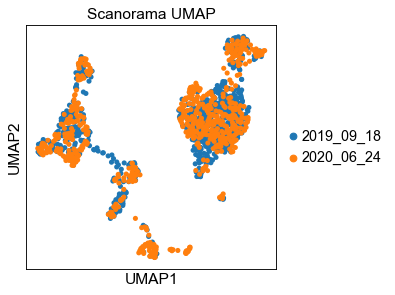

In [98]:
sc.pl.umap(adata, color='sortdate', title='Scanorama UMAP')

### Write & read data

In [99]:
adata.write_h5ad(h5ad_dir + 'adata.scanorama.h5ad')

In [100]:
adata = sc.read_h5ad(h5ad_dir + 'adata.scanorama.h5ad')

## Clustering

### Leiden

In [101]:
sc.tl.leiden(adata, key_added='leiden_1.0') # default resolution is 1.0
sc.tl.leiden(adata, resolution=0.6, key_added='leiden_0.6')
sc.tl.leiden(adata, resolution=0.4, key_added='leiden_0.4')
sc.tl.leiden(adata, resolution=1.4, key_added='leiden_1.4')

running Leiden clustering
    finished: found 14 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_1.4', the cluster labels (adata.obs, categorical) (0:00:00)


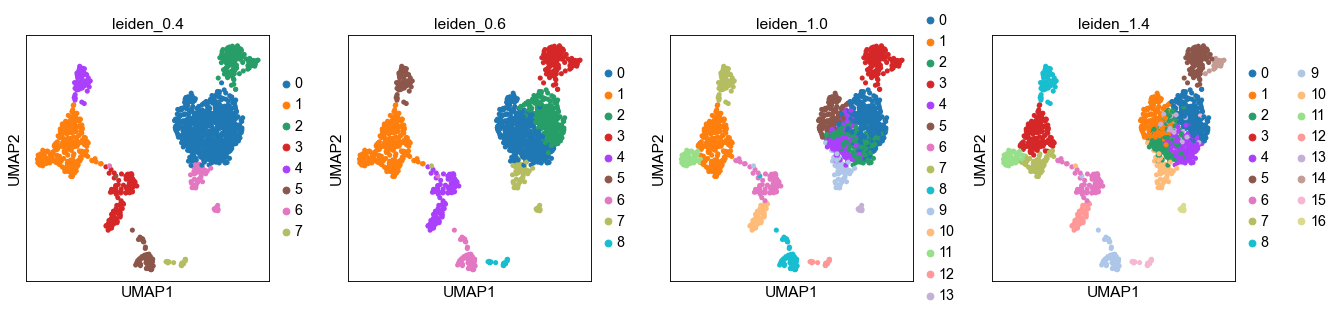

In [102]:
sc.pl.umap(adata, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4'])

### Louvain

In [103]:
sc.tl.louvain(adata, key_added='louvain_1.0')
sc.tl.louvain(adata, resolution=0.6, key_added='louvain_0.6')
sc.tl.louvain(adata, resolution=0.4, key_added='louvain_0.4')
sc.tl.louvain(adata, resolution=1.4, key_added='louvain_1.4')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_1.4', the cluster labels (adata.obs, categorical) (0:00:00)


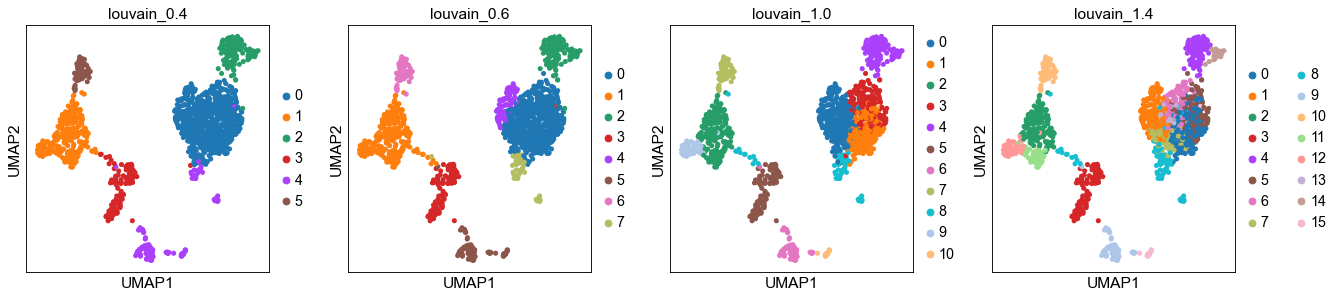

In [104]:
sc.pl.umap(adata, color=['louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4'])

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.4_6_sub', the cluster labels (adata.obs, categorical) (0:00:00)


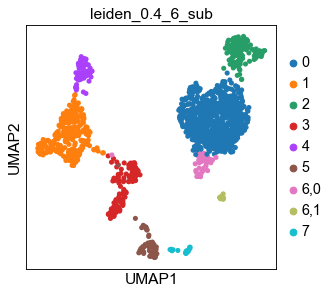

In [105]:
sc.tl.leiden(adata, restrict_to=('leiden_0.4', ['6']), resolution=0.2, key_added='leiden_0.4_6_sub')
sc.pl.umap(adata, color=['leiden_0.4_6_sub'])

running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.4_6_0_sub', the cluster labels (adata.obs, categorical) (0:00:00)


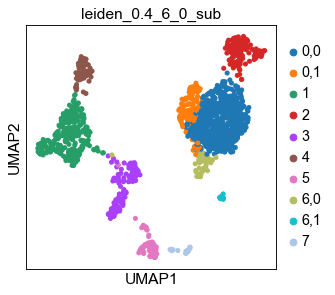

In [106]:
sc.tl.leiden(adata, restrict_to=('leiden_0.4_6_sub', ['0']), resolution=0.3, key_added='leiden_0.4_6_0_sub')
sc.pl.umap(adata, color=['leiden_0.4_6_0_sub'])

## Cell type

Cell type annotation from (Oprescu et al., 2020) was used as reference and R Seurat v3 ‘FindTransferAnchors’ and ‘TransferData’ methods were used applied for cell type prediction (Stuart et al., 2019). The marker genes used in the reference were further investigated to validate the predictions. Boundary cases where the cluster and prediction did not agree, cell types annotations were changed to follow the majority cells in the cluster. 

The details are not included, rather the final cell type assignment were loaded here.

In [107]:
clusters_d = {'2': '3',
              '0,0': '0',
              '0,1': '1', 
              '6,0': '2',
              '6,1': '4',
              '4': '5',
              '1': '6',
              '5': '7',
              '3': '8',
              '7': '9'}
adata.obs['cluster'] = [clusters_d[cl] for cl in adata.obs['leiden_0.4_6_0_sub']]

In [108]:
adata.uns['cluster_colors'] = np.array([   '#d62728', # 0 red
                                           '#aa40fc', # 1
                                           '#ff7f0e', # 2
                                           '#1f77b4', # 3, blue
                                           '#e377c2', # 4, pink
                                           '#b5bd61', # 5, green
                                           '#279e68', # 6, green
                                           '#17becf', # 7, light blue
                                           '#8c564b', # 8, brown
                                           '#aec7e8', # 9, light blue purpleish
                                           ])

In [109]:
clusters_ct_d = {'0': '0',
              '1': '1', 
              '2': '2',
              '3': 'APCs',
              '4': 'T-cells',
              '5': 'Tenocytes',
              '6': 'FAPs',
              '7': 'Endothelial cells',
              '8': 'Mural cells',
              '9': 'Monocytes'}
adata.obs['cluster_ct'] = [clusters_ct_d[cl] for cl in adata.obs['cluster']]
adata.obs['cluster_ct'] = adata.obs['cluster_ct'].astype('category').cat.\
    reorder_categories(['APCs', '0', '1', '2', 'Monocytes', 'T-cells', 'Tenocytes', 
                        'FAPs',  'Mural cells', 'Endothelial cells'])

In [110]:
adata.uns['cluster_ct_colors'] = np.array(['#1f77b4', # blue
                                           '#d62728', # 0 red
                                           '#aa40fc',
                                           '#ff7f0e',
                                           '#aec7e8', # light blue purpleish
                                           '#e377c2', # 4, pink
                                           '#b5bd61', # 5, green
                                           '#279e68', # 6, green
                                           '#8c564b', # brown
                                           '#17becf', # 7, light blue
                                           ])

In [111]:
adata.obs['cell_type'] = adata.obs['cluster_ct']
adata.obs['cell_type'].replace({'2':'Macrophages', '0':'Macrophages', '1':'Macrophages'}, inplace=True)
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category').cat.\
    reorder_categories(['APCs', 'Macrophages', 'Monocytes', 'T-cells', 'Tenocytes', 
                        'FAPs',  'Mural cells', 'Endothelial cells'])

In [112]:
adata.uns['cell_type_colors'] = np.array(['#1f77b4', # blue
                                          '#d62728', # 0 red
                                          '#aec7e8', # light blue purpleish
                                          '#e377c2', # 4, pink
                                          '#b5bd61', # 5, green
                                          '#279e68', # 6, green
                                          '#8c564b', # brown
                                          '#17becf', # 7, light blue
                                          ])

In [113]:
adata.uns['ischemia_colors'] = np.array(['#D56B12', '#B4B4B4'])

In [114]:
adata.uns['tdtomato_colors'] = np.array(['#64BF73', '#E52320'])

... storing 'cluster' as categorical


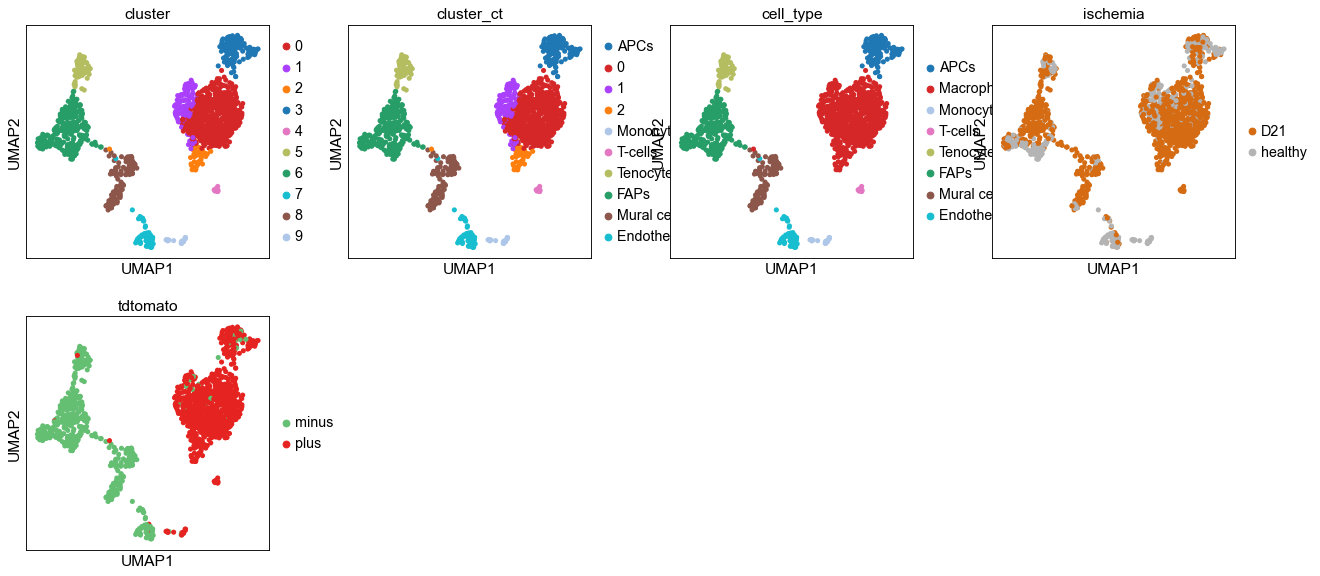

In [115]:
sc.pl.umap(adata, color = ['cluster', 'cluster_ct', 'cell_type', 'ischemia', 'tdtomato'])

### Save data

In [116]:
adata

AnnData object with n_obs × n_vars = 1425 × 7421
    obs: 'year', 'plate', 'well', 'n_reads', 'n_mapped_reads', 'p_mapped_reads', 'n_reads_in_features', 'p_reads_in_features', 'n_multi_mapped_reads', 'p_multi_mapped_reads', 'n_short_unmapped_reads', 'p_short_unmapped_reads', 'p_other', 'sortdate', 'cell_identity', 'ischemia', 'marker', 'sex', 'sorting_batch', 'PDGFRB_MFI', 'GFP', 'tdtomato', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'percent_chrY', 'XIST-counts', 'contamination', 'n_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_1.4', 'leiden_0.4_6_sub', 'leiden_0.4_6_0_sub', 'cluster', 'cluster_ct', 'cell_type'
    var: 'Chromosome', 'Source', 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', '

In [117]:
adata.write_h5ad(h5ad_dir + 'adata.ct.h5ad')